In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Core packages
import pygmo as pg
import numpy as np
from math import pi
from dotmap import DotMap

# For optimization using pygmo
from udp_initial_condition import udp_initial_condition

# For computing trajectory
from Trajectory import Trajectory
import pykep as pk

# For Plotting
import matplotlib.pyplot as plt

# For cProfile evaluation
import cProfile
import pstats

In [16]:
def setup_parameters():
    """Set up of required hyperparameters for the optimization scheme. 

    Returns:
        body_args (dotmap.DotMap): Paramteers relating to the celestial body:
            density (float): Body density of celestial body.
            mu (float): Gravitational parameter for celestial body.
            declination (float): Declination angle of spin axis.
            right_ascension (float): Right ascension angle of spin axis.
            spin_period (float): Rotational period around spin axis of the body.
        target_squared_altitude (float): Squared value of the satellite's orbital target altitude.
        final_time (float): Final time (in seconds) for the integration of trajectory.
        start_time (float): Start time (in seconds) for the integration of trajectory.
        time_step (float): Size of initial time step (in seconds) for integration of trajectory.
        lower_bounds (np.ndarray): Lower boundary values for the initial state vector.
        upper_bounds (np.ndarray): Lower boundary values for the initial state vector.
        algorithm (int): Choice of algorithm (see file Integrator for references).
        radius_bounding_sphere (float): Radius of the bounding sphere representing risk zone for collisions with celestial body.
        population_size (int): Number of chromosomes to compare at each generation.
        number_of_generations (int): Number of generations for the genetic opimization.
    """
    # Body parameters
    body_args = DotMap()
    body_args.density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    body_args.mu = 665.666                   # Gravitational parameter for 67P/C-G
    body_args.declination = 64               # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    body_args.right_ascension = 69           # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    body_args.spin_period = 12.06*3600       # [seconds] https://sci.esa.int/web/rosetta/-/14615-comet-67p

    # Setup hyperparameters:
    target_squared_altitude = 8000**2           # Target altitude squared
    final_time = 20*3600.0              # Final time [s]
    start_time = 0                      # Starting time [s]
    time_step = 600                     # Time step size for trajectory prodpagation. [s]
    radius_bounding_sphere = 4000       # Radius of the bounding sphere representing risk zone for collisions with celestial body.

    # Bounds for initial variable domain: [r_x,r_y,r_z,v_x,v_y,v_z]
    #lower_bounds, upper_bounds = np.array([-6000,-6000,-6000,0,0,0]),np.array([6000,6000,6000,2.5,2.5,2.5])

    # Defining the parameter space for the optimization
    #   (Parameters are defined in osculating orbital elements)
    a = [5000, 15000] # Semi-major axis
    e = [0, 1]        # Eccentricity [0, 1]
    o = [0, 2*pi]     # Right ascension of ascending node [0,2*pi]
    w = [0, 2*pi]     # Argument of periapsis [0, 2*pi]
    i = [0, pi]       # Inclination [0, pi] 
    ea = [0, 2*pi]    # Eccentric anomaly [0, 2*pi]

    lower_bounds = np.array([a[0], e[0], i[0], o[0], w[0], ea[0]])
    upper_bounds = np.array([a[1], e[1], i[1], o[1], w[1], ea[1]])

    # Choose numerical integrator:
    algorithm = 3

    # Optimization parameters
    population_size = 10 
    number_of_generations = 32 

    return body_args, target_squared_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations

Retrieving user defined parameters...
Setting up the UDP...
Setting up the optimization algorithm...
Initializing the optimization:

   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10    1.92509e+07       0.759117       0.796343        4984.58    6.58442e+08
      2             20    1.92509e+07       0.759117       0.796343        1708.79    4.76904e+08
      3             30    1.92509e+07       0.759117       0.796343        4986.22    3.87833e+08
      4             40    1.92509e+07       0.759117       0.796343        4986.22    3.87833e+08
      5             50    1.92509e+07       0.759117       0.796343        4981.25    3.11539e+08
      6             60    1.92509e+07       0.759117       0.796343        4981.17    2.66659e+08
      7             70    1.92509e+07       0.759117       0.796343        4981.17    2.66659e+08
      8             80    1.92509e+07       0.759117       0.796343        1414.09 

2023-03-05 22:17:58.733 (6911.653s) [            207E]       vtkAxesActor.cxx:424   WARN| One or more normalized shaft lengths       are < 0 or > 1 and may produce unexpected results.


BokehModel(combine_events=True, render_bundle={'docs_json': {'e1c9810d-981f-4e83-8038-4f240417c788': {'defs': …

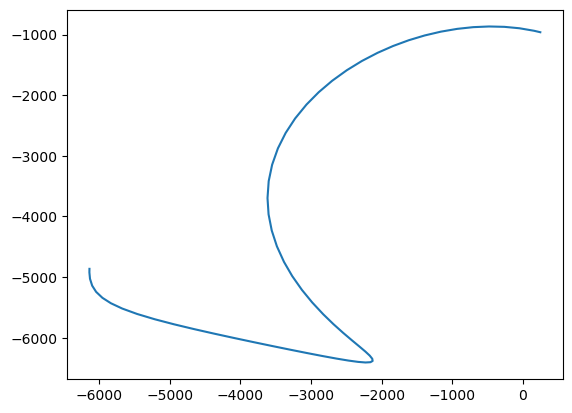

In [17]:
# Main script:

def run():
    """
    Main function for optimizing the initial state for deterministic trajectories around a 
    small celestial body using a mesh.
    """
    
    print("Retrieving user defined parameters...")
    body_args, target_squared_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere, population_size, number_of_generations = setup_parameters()

    # Setup User-Defined Problem (UDP)
    print("Setting up the UDP...")
    udp = udp_initial_condition(body_args, target_squared_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, radius_bounding_sphere)
    prob = pg.problem(udp)

    # Setup optimization algorithm
    print("Setting up the optimization algorithm...")
    assert population_size >= 7
    algo = pg.algorithm(pg.sade(gen = number_of_generations))
    pop = pg.population(prob = prob, size = population_size)
    
    # Run optimization
    print("Initializing the optimization:")
    algo.set_verbosity(1)
    pop = algo.evolve(pop)

    # Logs for output
    print("Champion fitness value: ", pop.champion_f) 
    print("Champion chromosome: ", pop.champion_x) 

    # Retrieving champion chromosome
    x = pop.champion_x

    # Convert osculating orbital elements to cartesian for integration
    r, v = pk.par2ic(E=x, mu=body_args.mu)
    x_cartesian = np.array(r+v)

    # Compute optimized trajectory
    trajectory = Trajectory(body_args, final_time, start_time, time_step, algorithm, radius_bounding_sphere)
    trajectory_info, _, _  = trajectory.integrate(x_cartesian)

    # Plot optimized trajectory
    trajectory.plot_trajectory(trajectory_info[0:3,:])

    plt.plot(trajectory_info[0,:],trajectory_info[1,:])

def main():
    run()

if __name__ == "__main__":
    cProfile.run("main()", "output.dat")

    with open("output_time.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("time").print_stats()
    
    with open("output_calls.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("calls").print_stats()
